# Intro to CFD HW6

**Author: Alex Choi** <br>
*Date: April 1, 2025*

## wave_solver:

In [126]:
import numpy as np
from sys import exit

# Adjust print options
np.set_printoptions(linewidth=250)  # Adjust the width limit

def wave_solve(c: float, L:float, n:int, Courant:float, T:float, M:int, u0, method:str) -> dict:
    """
    Parameters:
        c : float
            Advective speed (assumed positive).
        L : float
            Domain size [0, L].
        n : int
            Number of interior grid points.
        Courant : float
            Courant number.
        T : float
            Final time.
        M : int
            Number of solution snapshots between [0, T]
        u0 : callable
            Initial condition function: u0(x_array) -> array of same length.
        method : str
            One of {'forward-upwind', 'implicit-central', 'beam-warming', 'lax-wendroff'}.
`
    Returns
        dict:
            A dictionary with:
                out['h']   : float, spatial grid spacing
                out['k']   : float, base time step size
                out['l']   : int,   total number of time steps taken
                out['x']   : 1D array, spatial grid from 0 to L
                out['TT']  : 1D array, times at which solutions are recorded
                out['U']   : 2D array, solution snapshots; out['U'][:, j] is the solution at time out['TT'][j]
    """
    # Initialize output
    result = {}
    
    ###############################################
    # 1. Spatial grid
    h = L / (n + 1)  # get the space-step-size
    result['h'] = h 
    
    # generate spatial points to compute solutions about:
    spatial_grid = np.linspace(0, L, n+2)  # n interior points => n+2 total
    result['x'] = spatial_grid
    N = len(spatial_grid)  # number of total points, should be equal to n+2
    exit(f"Total Number of Points (N = {N}) doesn't equal Number of Interior Points (n) + 2 = {n+2}") if N != n+2 else None
    ###############################################
    # 2. Times at which we store solutions
    TT = np.linspace(0, T, M+2)  # from 0 to T, M+2 points
    result['TT'] = TT
    ###############################################
    # 3. ideal Time-step size from user-defined Courant number
    k = Courant * h / c # biggest time-step-size that can be taken while preserving stability
    result['k'] = k
    ###############################################
    # 4. Build/update coeff matrix based on method
    match method.lower():
        case'forward-upwind':
            if c < 0:
                raise ValueError("Please specify a positive advective speed.")
            # Create an N×N matrix A for delta U, for (-U^n_i + U^n_i-1)
            A = -np.diag(np.ones(N)) + np.diag(np.ones(N-1), k=-1)
            # Periodic boundary condition on U(1) = U0 equals U_N
            A[0, n] = 1.0

        case 'implicit-central':
            Courant_stable = min(TT[1] - TT[0], k) * c / h
            # need ot create a Coeff * U_new = U_old system.
            A = np.zeros(shape = (N, N))
            # main diagonals are 2s:
            np.fill_diagonal(A, 2)
            # sub-diagonals are -Courant
            np.fill_diagonal(A[1:], -Courant_stable)
            # super-diags are +Courant
            np.fill_diagonal(A[:-1, 1:], Courant_stable)
            # apply bounary conditions
            A[0, n] = -Courant_stable # for left boundary, U_-1  = U_n
            A[-1,1] = Courant_stable # for right boundary, U_n+2 = U_1

        case 'beam-warming':
            # create N by N matrix
            A = np.zeros(shape=(N, N))
            alpha = (Courant**2 - Courant) / 2 # coeff in front of U_i-2 term
            beta = 2*Courant - Courant**2 # coeff in front of U_i-1 term
            gamma = (Courant ** 2 - 3*Courant) / 2 # coeff. in front of U_i term:
            # main diagonals
            np.fill_diagonal(A, val = gamma)
            # sub diagonals
            np.fill_diagonal(A[1:], beta)
            # sub-sub diagonal
            np.fill_diagonal(A[2:], alpha)
            # apply Periodic BCs:
            # for the i = 0 or the 1st row:
            ## i = -2 -> n - 1
            A[0, n-1] = alpha
            ## i = -1 -> n
            A[0, n] = beta
            # for the i = 1 or the 2nd row:
            ## i = -1 -> i = n
            A[1, n] = alpha

        case 'lax-wendroff':
            # create N by N matrix
            A = np.zeros(shape=(N, N))
            alpha = (Courant**2 + Courant) / 2 # coeff in front of U_i-1 term
            beta = -Courant ** 2 # coeff in front of U_i term
            gamma = (Courant ** 2 - Courant) / 2 # coeff. in front of U_i+1 term:
            # main diagonals
            np.fill_diagonal(A, val = beta)
            # sub diagonals
            np.fill_diagonal(A[1:], alpha)
            # super diagonal
            np.fill_diagonal(A[:-1, 1:], gamma)
            # apply Periodic BCs:
            # for the i = 0 or the 1st row:
            ## i = -1 -> n
            A[0, n] = alpha
            # for the last row:
            ## i = n+2 -> i = 1
            A[-1, 1] = gamma

        case _:
            raise ValueError("Unknown method.")
    ###############################################
    # 5. Solution Calculations
    # Prepare storage for solutions at each time in TT
    U = np.zeros((N, M+2)) # for N = n+2 points and M + 2 time snap-shots
    ## indices for use:
    num_time_steps = 0   # total number of time steps
    j = 0  # accessing solution matrix column
    t = 0.0 # time
    ## compute inital condition on spatial grid:
    U_temp = u0(spatial_grid)  # 1D NumPy array for t = 0, j = 0
    exit("u0(x) must return an array of length N = n+2.") if len(U_temp) != N else None
    U[:, j] = U_temp # initial condition at t = 0 or j = 0
    j += 1 # advance to next column.

    ## Time integration
    while (t < TT[-1]): # run until the end time
        # we already computed max 'k' that can be used for stable solution
        # however, user might want to store the sol at smaller increment that is still stable
        # we only use user defined time step size from spatial_grid if it's stable (smaller than theoretical k)
        k_stable = min(TT[j] - t, k)
        Courant_stable = k_stable * c / h 
        # print(f"Time: {t:.6f}; Courant = {Courant_stable:.6f}; Time step = {k_stable:.6f}")

        # Zero the update for a j-th column of U matrix.
        dU = np.zeros_like(U_temp) # 1d array

        # Method-specific update
        match method.lower():
            case 'forward-upwind':
                # Simple explicit Euler + forward-upwind operator
                dU = Courant_stable * (A @ U_temp)
                # Update solution
                U_temp += dU

            case 'implicit-central':
                # solve the new U vector using current U_temp and A matrix
                U_temp = np.linalg.solve(A, 2 * U_temp)

            case 'beam-warming':
                # apply delta U to current U
                dU = A @ U_temp
                # update
                U_temp += dU

            case 'lax-wendroff':
                # apply delta U to current U
                dU = A @ U_temp
                # update
                U_temp += dU
            case _:
                exit("Method is unknwon!")
        
        # Advance indices
        num_time_steps += 1 
        t += k_stable # advance time

        # If we've just hit the next snapshot time that user defined, store the solution.
        if np.isclose(t, TT[j]):
            # Record the solution
            TT[j] = t  # ensure no floating rounding error
            U[:, j] = U_temp
            j += 1 # move to next time step / col in sol mx

    # 7. Finalize outputs
    result['U'] = U
    result['l'] = num_time_steps

    return result

## Question 1

In [127]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

interior_grid_points = [25, 50, 100, 200, 400] # increasingly finer meshes
T = 4 * np.pi # integration domain
Courant_nums = [0.25, 0.50, 0.75]
adv_speed = 1.0
space_interval = 2 * np.pi
u0 = lambda x: np.sin(x)

# Set up Seaborn with high-contrast color palette
sns.set_theme(style="darkgrid")
palette = sns.color_palette("colorblind", n_colors=len(interior_grid_points))
markers = ['o', 's', '*', 'v', 'x']

### 1a
For σ = 0.75 only, produce two plots, one for each method, that show the solutions at t = T for all 5 mesh resolutions.

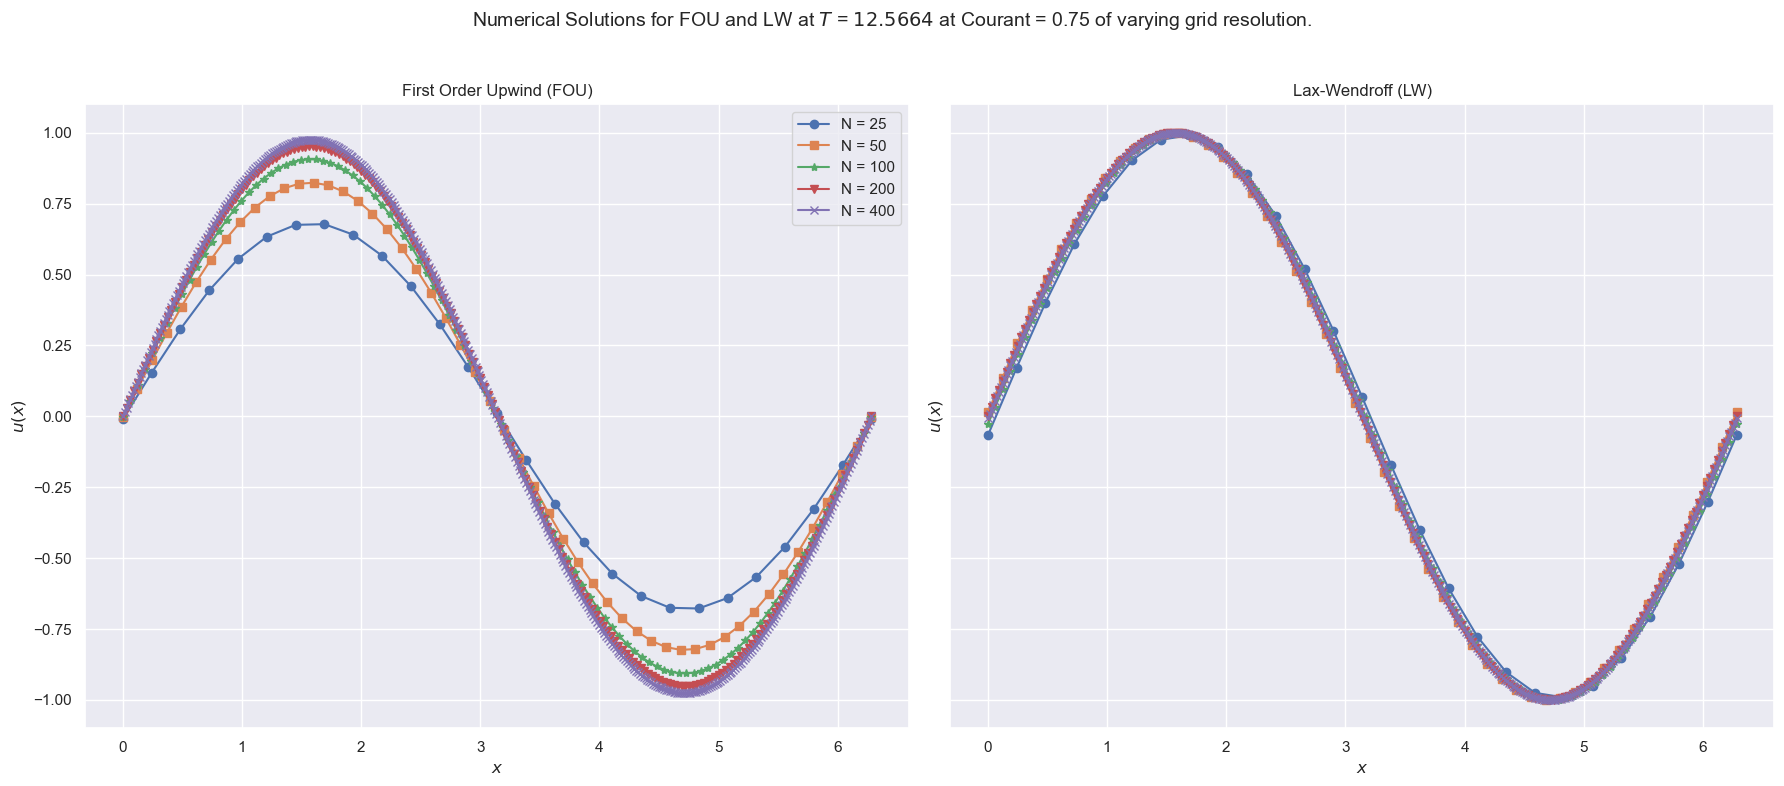

In [128]:
# fig for two plots
fig, axes = plt.subplots(nrows = 1, ncols  = 2, figsize = (18,8), sharey = True)
fig.suptitle(f"Numerical Solutions for FOU and LW at $T$ = ${T:.4f}$ at Courant = 0.75 of varying grid resolution.", fontsize=14)

# iterate over grid resolutions:
for i, num_interior_pts in enumerate(interior_grid_points):
    # compute FOU solution:
    FOU = wave_solve(c = adv_speed, L = space_interval, n = num_interior_pts, Courant=0.75, T = T, M=0, u0=u0, method='forward-upwind')
    # compute LW solution:
    LW = wave_solve(c = adv_speed, L = space_interval, n = num_interior_pts, Courant=0.75, T = T, M=0, u0=u0, method = 'lax-wendroff')
    # plot both methods to respective plot position
    axes[0].plot(FOU['x'], FOU['U'][:, -1], marker=markers[i], linewidth=1.5, label=f'N = {num_interior_pts}')
    axes[1].plot(LW['x'], LW['U'][:, -1], marker=markers[i], linewidth=1.5, label=f'N = {num_interior_pts}')

# Formatting
axes[0].set_title(f"First Order Upwind (FOU)"), axes[1].set_title(f"Lax-Wendroff (LW)")
axes[0].set_xlabel("$x$"), axes[1].set_xlabel("$x$")
axes[0].set_ylabel("$u(x)$"), axes[1].set_ylabel("$u(x)$")
axes[0].legend(), axes[0].legend()
axes[0].grid(True), axes[1].grid(True)

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 1b
Produce one plot (on a log-log scale) that shows the error e as a function of 1/h. You will have 6 datasets on this one plot, so make sure to label them clearly, and use adequate line styles to distinguish one dataset from the other.

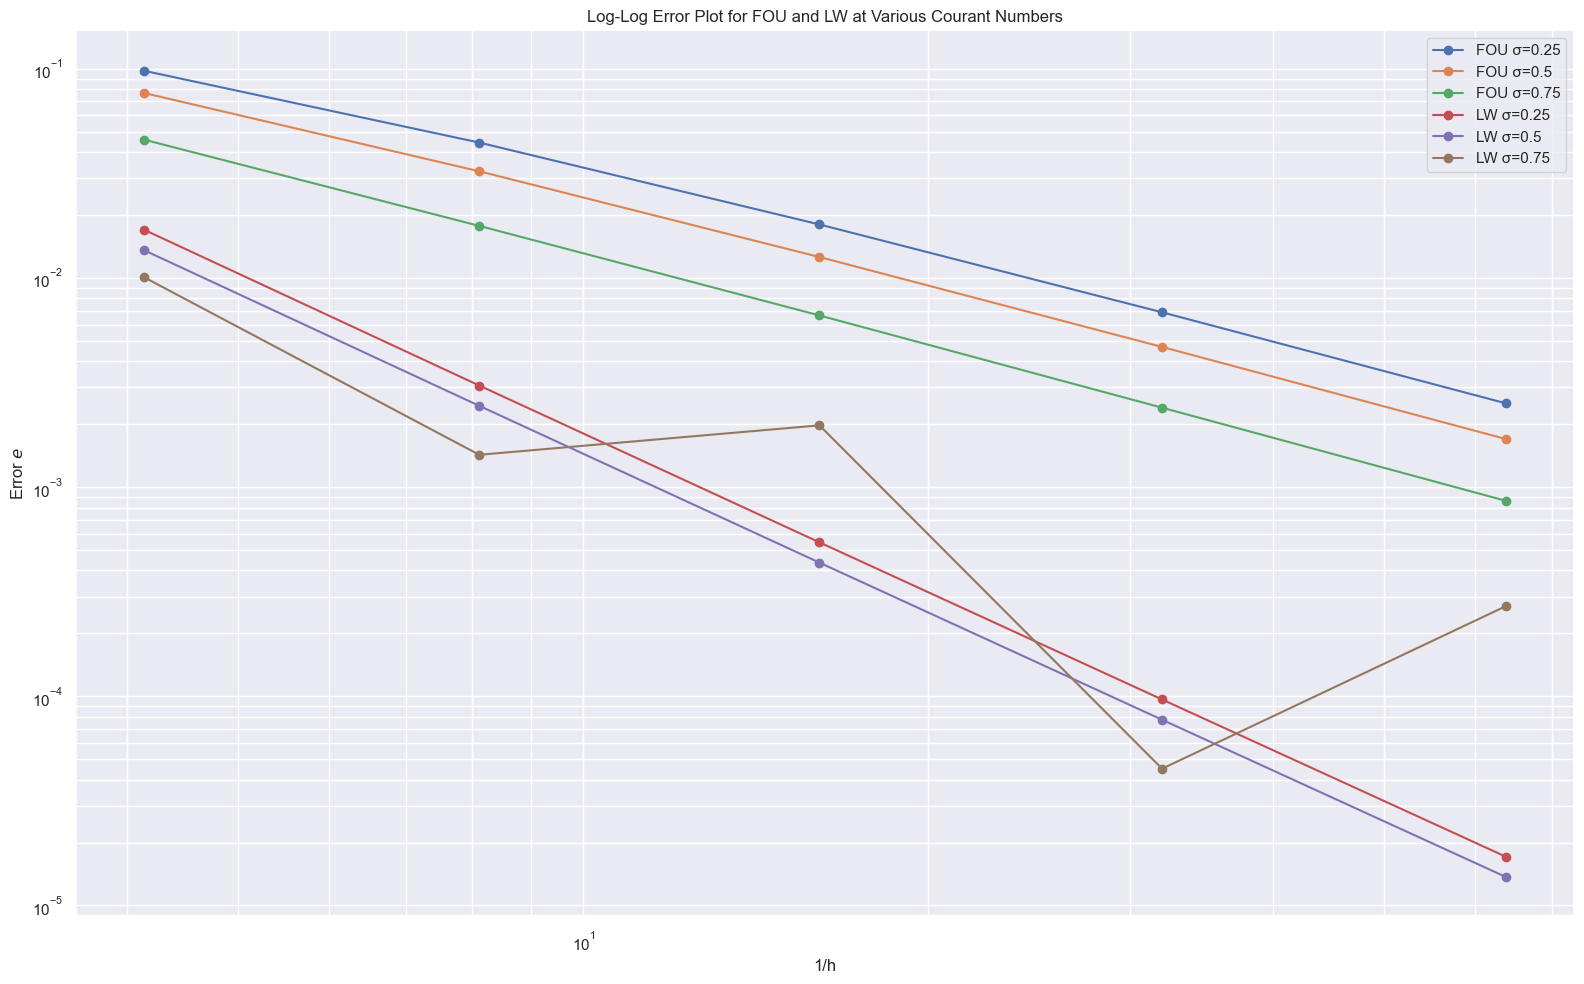

In [129]:
def compute_error(N: int, exact: np.ndarray, numerical: np.ndarray) -> float:
    """
    Computes the error e.

    Parameters:
        N (int): Number of interior points
        exact (np.array): Interpolated exact solution at grid points
        numerical (np.array): Numerical solution

    Returns:
        float: error (e)
    """
    return np.sqrt(np.sum((numerical - exact) ** 2)) / float(N)

# Store errors
errors = {
    'FOU_0.25': [],
    'FOU_0.5': [],
    'FOU_0.75': [],
    'LW_0.25': [],
    'LW_0.5': [],
    'LW_0.75': []
}

def exact_sol(x: np.ndarray, c: float, T: np.ndarray):
    return np.sin(x - c * T)

# compute all the errors:
for i, N in enumerate(interior_grid_points):
    for Courant in Courant_nums:
        # compute FOU:
        FOU = wave_solve(c=adv_speed, L=space_interval, n=N, Courant=Courant, T=T, M=0, u0=u0, method='forward-upwind')
        # compute FOU error:
        FOU_err = compute_error(N, exact_sol(FOU['x'], adv_speed, FOU['TT'][-1]), FOU['U'][:, -1])
        # store it in the dictionary:
        errors[f'FOU_{Courant}'].append(FOU_err)

        # compute LW:
        LW = wave_solve(c=adv_speed, L=space_interval, n=N, Courant=Courant, T=T, M=0, u0=u0, method='lax-wendroff')
        # compute FOU error:
        LW_err = compute_error(N, exact_sol(LW['x'], adv_speed, LW['TT'][-1]), LW['U'][:, -1])
        # store it in the dictionary:
        errors[f'LW_{Courant}'].append(LW_err)


# Grid spacings
hs = [(2 * np.pi) / (N + 1) for N in interior_grid_points]
inv_hs = [1/h for h in hs]

# create a plot for E and e
plt.figure(figsize=(16, 10)) # creare a subplot
for key, e_list in errors.items():
    method, sigma = key.split('_')
    plt.loglog(inv_hs, e_list, marker='o', label=f"{method} σ={sigma}")

plt.xlabel("1/h")
plt.ylabel("Error $e$")
plt.title("Log-Log Error Plot for FOU and LW at Various Courant Numbers")
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()

**NOTE to the grader**: I have no idea why for LW at 0.75 I see the weird fluctuation.

### 1c
Here, we fit a function of the form $Ch^\alpha$ and report the value of $\alpha$ for $\log(e)$.
Then, we make a conclusion about the order of the errors with respect to $h = (N + 1)^{-1}$.
Since we take the log of the function $Ch^\alpha$, our function becomes:

$$
\log(e) = \log(C) + \alpha \log(h)
$$

This transformation allows us to express the relationship in a linear form:

$$
y = m x + b
$$

where $y = \log(e)$, $x = \log(h)$, slope $m = \alpha$, and intercept $b = \log(C)$.


In [130]:
from scipy.stats import linregress

# stores alpha and C values.
alphas = []
Cs = []

hs = [(2 * np.pi) / (N + 1) for N in interior_grid_points]
inv_hs = [1/h for h in hs]

methods = ['FOU 0.25', 'FOU 0.5', 'FOU 0.75', 'LW 0.25', 'LW 0.5', 'LW 0.75']

for key, error_list in errors.items():
    # Regression: log(error) vs. log(1/h), slope = -alpha
    slope, intercept = linregress(np.log(inv_hs), np.log(error_list))[:2]
    alpha = -slope 
    C = np.exp(intercept)

    alphas.append(alpha)
    Cs.append(C)

import pandas as pd
# alphas and Cs already populated
methods = ['FOU', 'FOU', 'FOU', 'LW', 'LW', 'LW']
sigmas = [0.25, 0.50, 0.75, 0.25, 0.50, 0.75]

# Convert short method names to full ones
method_full = ['Forward-Upwind' if m == 'FOU' else 'Lax-Wendroff' for m in methods]

# Build the DataFrame
df = pd.DataFrame({
    'Method': method_full,
    'σ': sigmas,
    'α': alphas,
    'C': Cs
})

print(df)


           Method     σ         α         C
0  Forward-Upwind  0.25  1.343716  0.709265
1  Forward-Upwind  0.50  1.396578  0.585512
2  Forward-Upwind  0.75  1.455049  0.370080
3    Lax-Wendroff  0.25  2.522999  0.607511
4    Lax-Wendroff  0.50  2.522434  0.485038
5    Lax-Wendroff  0.75  1.562290  0.062563


### Table of Fitted Parameters

| Method           | σ    | α     | C     |
|------------------|------|-------|-------|
| Forward–Upwind   | 0.25 | 1.344 | 0.709 |
| Forward–Upwind   | 0.50 | 1.397 | 0.586 |
| Forward–Upwind   | 0.75 | 1.455 | 0.370 |
| Lax–Wendroff     | 0.25 | 2.523 | 0.608 |
| Lax–Wendroff     | 0.50 | 2.522 | 0.485 |
| Lax–Wendroff     | 0.75 | 1.562 | 0.063 |

### Commentary on Error Trends

#### Order of Accuracy (α)

- For the **Forward-Upwind (FOU)** method, α values range from approximately 1.3–1.5, consistent with the expected **first-order accuracy** from the leading truncation error term $ \mathcal{O}(h) $. The scheme is dissipative, dominated by the $ u_{xx} $ term. It is bit higher than expected.
- For the **Lax–Wendroff (LW)** method, α is close to **2.5** for σ = 0.25 and 0.50, aligning well with the expected **second-order accuracy** due to the leading $ \mathcal{O}(h^2) $ dispersive term $ u_{xxx} $. Again, it is bit higher than expected.

At **σ = 0.75**, LW shows a lower α value (1.562), which is inconsistent with expectations. This is likely due to a bug in the code or a plotting/data issue and should be revisited for verification. For now, we treat this case as an outlier and not representative of the method's actual behavior.

#### Influence of Courant Number (σ)

- **Forward-Upwind**:
  - Slight increase in α as σ increases, indicating marginal accuracy improvement.
  - The error constant C decreases with σ, suggesting reduced overall error despite a modest gain in convergence rate.

- **Lax-Wendroff**:
  - Stable α near 2.5 for σ = 0.25 and 0.50, reflecting strong second-order accuracy.
  - The error constant C again decreases as the Courant number goes up.
  - As noted, the drop at σ = 0.75 is likely an anomaly due to implementation or analysis error.

#### Comparison Between Methods

- **Lax-Wendroff outperforms Forward-Upwind** in terms of accuracy (higher α) and lower error (𝒞) for the lower Courant numbers.
- **Forward-Upwind is more stable and consistent** across varying σ values, though at the cost of reduced accuracy.

### Connection to Truncation Error

From the theoretical expressions:
- **FOU** has $ \mathcal{O}(h) $ truncation error with leading dissipative term $ u_{xx} $.
- **LW** has $ \mathcal{O}(h^2) $ truncation error with leading dispersive term $ u_{xxx} $.

Observed values support these expectations:
- **FOU**: α ≈ 1 → consistent with theory.
- **LW**: α ≈ 2.5 for σ = 0.25 and 0.50 → consistent with second-order behavior.

The deviation at σ = 0.75 for LW is treated as a data artifact for now.

### Conclusion

- **Grid spacing $ h $**: Smaller h leads to lower error for both methods, as expected.
- **Courant number $ \sigma $**: Has a clear impact on both error magnitude and convergence behavior—more so for Lax-Wendroff.
- **Method choice**:
  - **Lax-Wendroff** offers higher accuracy but is more sensitive to implementation and parameter changes.
  - **Forward-Upwind** is more stable and easier to implement but has lower accuracy.

Overall, these findings align with theoretical expectations from truncation error analysis and give practical insights into method selection for solving hyperbolic PDEs numerically.


## Question 2
### 2a — Phase Angle $ \beta $

We are given a wavelength $ \lambda = 2\pi $, and asked to evaluate the phase angle $ \beta $ for several grid sizes $ N $. The phase angle is defined as:

$$
\beta = \frac{2\pi}{N}
$$

This directly relates to the **spatial resolution**: the more grid points $ N $, the smaller the phase angle $ \beta $, meaning we can resolve finer features of the wave.

### Table of $ (N, \beta) $ Pairs

| $ N $ | $ \beta = \frac{2\pi}{N} $ (rad) |
|--------|-----------------------------|
| 25     | 0.2513                      |
| 50     | 0.1257                      |
| 100    | 0.0628                      |
| 200    | 0.0314                      |
| 400    | 0.0157                      |

### Interpretation

As $ N $ increases, the phase angle $ \beta $ **decreases**. This reflects the fact that higher spatial resolution (more grid points) allows us to capture finer wave features, i.e., higher frequency components of the solution. A smaller $ \beta $ corresponds to a more accurate representation of the true wave behavior.

In terms of error analysis and amplification factors $ g(\beta, \sigma) $, smaller $ \beta $ tends to reduce both dissipation and dispersion errors, improving the fidelity of the numerical solution. Hence, increasing $ N $ improves spatial resolution and reduces numerical error.


### 2b


/var/folders/yv/s7706vxn6hzb2hlqn5jk72m00000gn/T/ipykernel_19195/2831270587.py:26: RuntimeWarning: invalid value encountered in divide
  relative_phase_fou = phi_g_fou / phi_exact
/var/folders/yv/s7706vxn6hzb2hlqn5jk72m00000gn/T/ipykernel_19195/2831270587.py:34: RuntimeWarning: invalid value encountered in divide
  relative_phase_lw = phi_g_lw / phi_exact


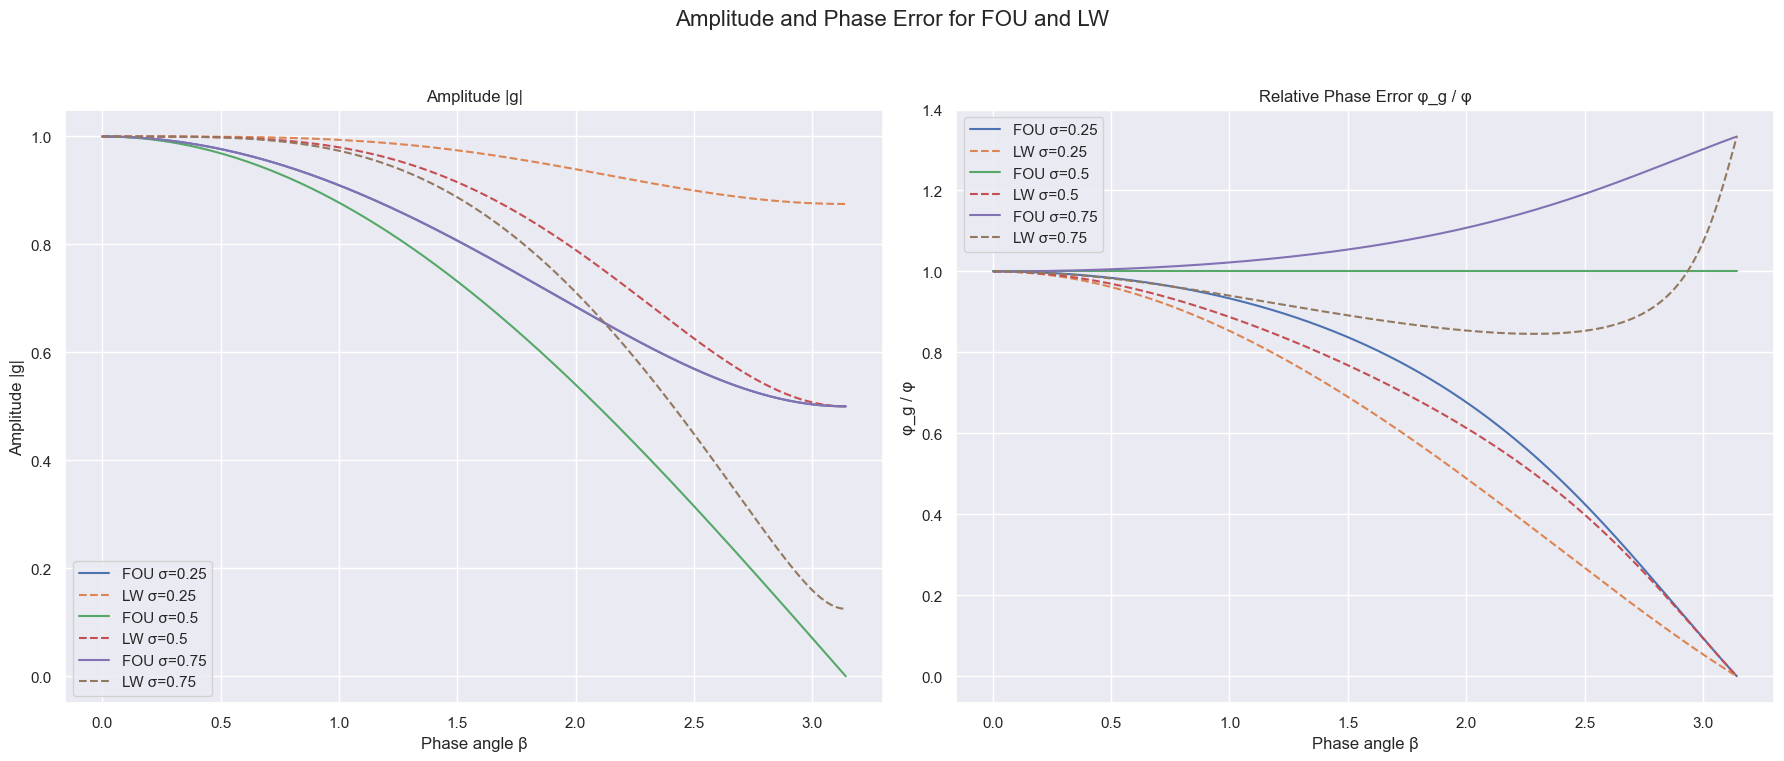

In [131]:
import numpy as np
import matplotlib.pyplot as plt

# Setup
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8), sharey=False)
fig.suptitle("Amplitude and Phase Error for FOU and LW", fontsize=16)

betas = np.linspace(0, np.pi, num=1000)
sigmas = [0.25, 0.50, 0.75]

def amp_factor_FOU(sigma, beta):
    return (1 - sigma + sigma * np.cos(beta)) - 1j * sigma * np.sin(beta)

def amp_factor_LW(sigma, beta):
    return 1 - sigma**2 + sigma**2 * np.cos(beta) - 1j * sigma * np.sin(beta)

# Loop over σ and plot both |g| and phase error
for sigma in sigmas:
    phi_exact = -sigma * betas
    epsilon = 1e-10

    # FOU
    g_fou = amp_factor_FOU(sigma, betas)
    abs_g_fou = np.abs(g_fou)
    phi_g_fou = np.angle(g_fou)
    relative_phase_fou = phi_g_fou / phi_exact

    axes[0].plot(betas, abs_g_fou, label=f"FOU σ={sigma}")
    axes[1].plot(betas, relative_phase_fou, label=f"FOU σ={sigma}")
    # LW
    g_lw = amp_factor_LW(sigma, betas)
    abs_g_lw = np.abs(g_lw)
    phi_g_lw = np.angle(g_lw)
    relative_phase_lw = phi_g_lw / phi_exact

    axes[0].plot(betas, abs_g_lw, linestyle='--', label=f"LW σ={sigma}")
    axes[1].plot(betas, relative_phase_lw, linestyle='--', label=f"LW σ={sigma}")

# Labels and legends
axes[0].set_title("Amplitude |g|")
axes[0].set_xlabel("Phase angle β")
axes[0].set_ylabel("Amplitude |g|")
axes[0].legend()
axes[0].grid(True)

axes[1].set_title("Relative Phase Error φ_g / φ")
axes[1].set_xlabel("Phase angle β")
axes[1].set_ylabel("φ_g / φ")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### 2c

The phase angle $\beta$ is:

$$
\beta = \frac{2\pi}{\lambda} h
$$

Plugging in our values for $\lambda$ and $h$ gives us:

$$
\beta = \frac{2\pi}{2\pi} \cdot 0.1 = 0.1
$$

#### 1. Forward-Upwind:

The **amplification factor** for the Forward-Upwind method is:

$$
g_{\text{FOU}} = 1 - \sigma + \sigma \cos(\beta) - i\sigma \sin(\beta)
$$

The **amplitude error** is given by the magnitude:

$$
|g_{\text{FOU}}| = |1 - \sigma + \sigma \cos(\beta) - i\sigma \sin(\beta)|
$$

Substituting $\sigma = 0.5$ and $\beta = 0.1$, we get:

$$
|g_{\text{FOU}}| = |1 - 0.5 + 0.5 \cos(0.1) - i0.5 \sin(0.1)|
$$

Simplifying:

$$
|g_{\text{FOU}}| = |0.5 + 0.5 \cdot 0.995 - i0.5 \cdot 0.0998| = |0.9975 - 0.0499i|
$$

$$
\Rightarrow |g_{\text{FOU}}| = \sqrt{(0.9975)^2 + (-0.0499)^2} \approx 0.9988
$$

We want to find such that:

$$
|g|^n = \frac{A_{n+1}}{A_n} = \frac{1}{2}
$$

Rearranging for n after taking log of both sides gives us:
$$
\ln(|g|^n) = \ln\left(\frac{1}{2}\right)
$$

$$
n \cdot \ln(|g|) = \ln\left(\frac{1}{2}\right)
$$

$$
n = \frac{\ln\left(\frac{1}{2}\right)}{\ln(|g|)}
$$

Plugging in our values for $|g|$ gives us:
$$
n = \frac{\ln\left(\frac{1}{2}\right)}{\ln(0.9988)} = 577.27 \approx 577
$$


#### 2. Lax-Wendroff:

The **amplification factor** for the Lax-Wendroff method is given by:

$$
g_{\text{LW}} = 1 - \sigma^2 + \sigma^2 \cos(\beta) - i\sigma \sin(\beta)
$$

The **amplitude error** is given by the magnitude:

$$
|g_{\text{LW}}| = |1 - \sigma^2 + \sigma^2 \cos(\beta) - i\sigma \sin(\beta)|
$$

Substituting $\sigma = 0.5$ and $\beta = 0.1$, we get:

$$
|g_{\text{LW}}| = |1 - 0.5^2 + 0.5^2 \cos(0.1) - i0.5 \sin(0.1)|
$$

Simplifying the expression gives us:

$$
|g_{\text{LW}}| = |0.75 + 0.25 \cdot 0.995 - i0.5 \cdot 0.0998| = |0.9988 - 0.0499i|
$$

$$
\Rightarrow |g_{\text{LW}}| = \sqrt{(0.9988)^2 + (-0.0499)^2} \approx 0.9999
$$

We want to find $ n $ such that:

$$
|g|^n = \frac{A_{n+1}}{A_n} = \frac{1}{2}
$$

Rearranging for $ n $ after taking the logarithm of both sides gives us:

$$
\ln(|g|^n) = \ln\left(\frac{1}{2}\right)
$$

$$
n \cdot \ln(|g|) = \ln\left(\frac{1}{2}\right)
$$

$$
n = \frac{\ln\left(\frac{1}{2}\right)}{\ln(|g|)}
$$

Plugging in our value for $ |g| $, we get:

$$
n = \frac{\ln\left(\frac{1}{2}\right)}{\ln(0.9999)} = 6931.47 \approx 6931
$$

So it would take approximately **6931 time steps** for the amplitude to reduce by half when using Lax-Wendroff. More precisely, it would take **infinite** steps as $ln(0.9999) \approx ln(1) = 0$ and dividng by $0$ leads to infinity.

To recap:
- for FOU, it would take around 577 steps to reach half of the exact solutoin's amplitude.
- for LW, it would take around 6931 steps (with rounding) to reac half of the exact solutoin's amplitude, almost 12 times more steps, hinting at its superiority.

### 2d

Recall for 2c, the amplitude error for FOU is:
$$
|g_{\text{FOU}}| = |1 - \sigma + \sigma \cos(\beta) - i\sigma \sin(\beta)|
$$

Replacing $\beta$ with $h$ as $\lambda = 2\pi$, simplifes the equation to:
$$
|g_{\text{FOU}}| = |1 - \sigma + \sigma \cos(h_{FOU}) - i\sigma \sin(h_{FOU})|
$$

To get the desired $h_{FOU}$, we set the expression equal to the value we got from 2c:
$$
|g_{\text{FOU}}| = |1 - \sigma + \sigma \cos(h_{FOU}) - i\sigma \sin(h_{FOU})| = |g_{LW}| = 0.9999976601505842
$$

Simplifying the expression gives us:

$$
|g_{\text{FOU}}| = \sqrt{(1 - 0.5 + 0.5 \cos(h_{FOU}))^2 + (-0.5 \sin(h_{FOU}))^2} = 0.9999976601505842
$$
Squaring the both sides:
$$
(0.9999976601505842)^2 = (1 - 0.5 + 0.5 \cos(h_{\text{FOU}}))^2 + (-0.5 \sin(h_{\text{FOU}}))^2
$$

Expanding and solving for $h_{FOU}$ gives us:
$$
(0.5 + 0.5 \cos(h_{\text{FOU}}))^2 + (0.5 \sin(h_{\text{FOU}}))^2 = (0.9999976601505842)^2
$$

$$
\cos(h_{\text{FOU}}) = 0.9999953203011684
$$

$$
h_{\text{FOU}} = 0.0030593144596429965 \approx 0.00306
$$

$$
h_{\text{FOU}} \approx 0.00306
$$



As we saw from our calculations, to achieve the same amplitude error as the Lax-Wendroff (LW) method with a grid spacing of $ h = 0.1 $, the Forward-Upwind (FOU) method would require a much finer grid — specifically, a grid spacing of approximately $ h = 0.00306 $. This means the FOU method would need over **32 times more grid points** in one spatial dimension.

When extended to three dimensions, this difference becomes even more significant. Since the number of grid points grows with the cube of the number of intervals in each direction, using FOU would require:

$$
\left(\frac{0.1}{0.00306}\right)^3 \approx 33^3 \approx 34900
$$

times more grid points than LW for the same accuracy in amplitude. This results in substantially higher memory usage and computational cost.

Therefore, we see a major advantage in using a **second-order method** like LW over a **first-order method** like FOU. LW achieves higher accuracy with significantly fewer grid points, making it far more efficient — especially in large-scale 2D and 3D simulations. In practical applications, this can drastically reduce runtime and resource requirements while maintaining or even improving solution quality.
